# Set up (FlowJo)

In [4]:
# ============================================================================
# Set csv path
# ============================================================================
path <- '/home/workspace/pbmc_flow/data/FH PBMC T Cell data - Cleaned Counts.csv'

# ============================================================================
# Set plot display options and load required libraries
# ============================================================================
options(repr.plot.width = 16, repr.plot.height = 20)  # Set large plot dimensions for multi-panel display

library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)
library(patchwork)    # Combining multiple plots into panels

# ============================================================================
# Load data and identify all subjects for analysis
# ============================================================================
df <- read.csv(path)  # Load cleaned PBMC data

# ============================================================================
# Show dataframe column names
# ============================================================================
names(df)

[1] "AIFI.Barcode"        "Sample.Kit.Barcode"  "Subject"            
 [4] "Visit"               "Visit.Type"          "CD45..count"        
 [7] "B.cells.count"       "T.cells.count"       "CD8.T.cells.count"  
[10] "Naive.CD8..count"    "TEMRA.CD8.count"     "EM.CD8.count"       
[13] "CM.CD8.count"        "CD4.T.cells.count"   "TREG.count"         
[16] "Memory.TREG.count"   "Naive.TREG.count"    "TEMRA.CD4.count"    
[19] "EM.CD4.count"        "Naive.CD4.count"     "CM.CD4.count"       
[22] "TFH.CD4.count"       "DP.T.cells.count"    "DN.T.cells.count"   
[25] "CD4.RM.count"        "CD8.RM.count"        "NK.Cells.count"     
[28] "Myeloid.cells.count"

# Using counts

## Level 1 Celltypes

### Alluvial Plot

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(count_cols)

  # Now:
  data %>% select(all_of(count_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


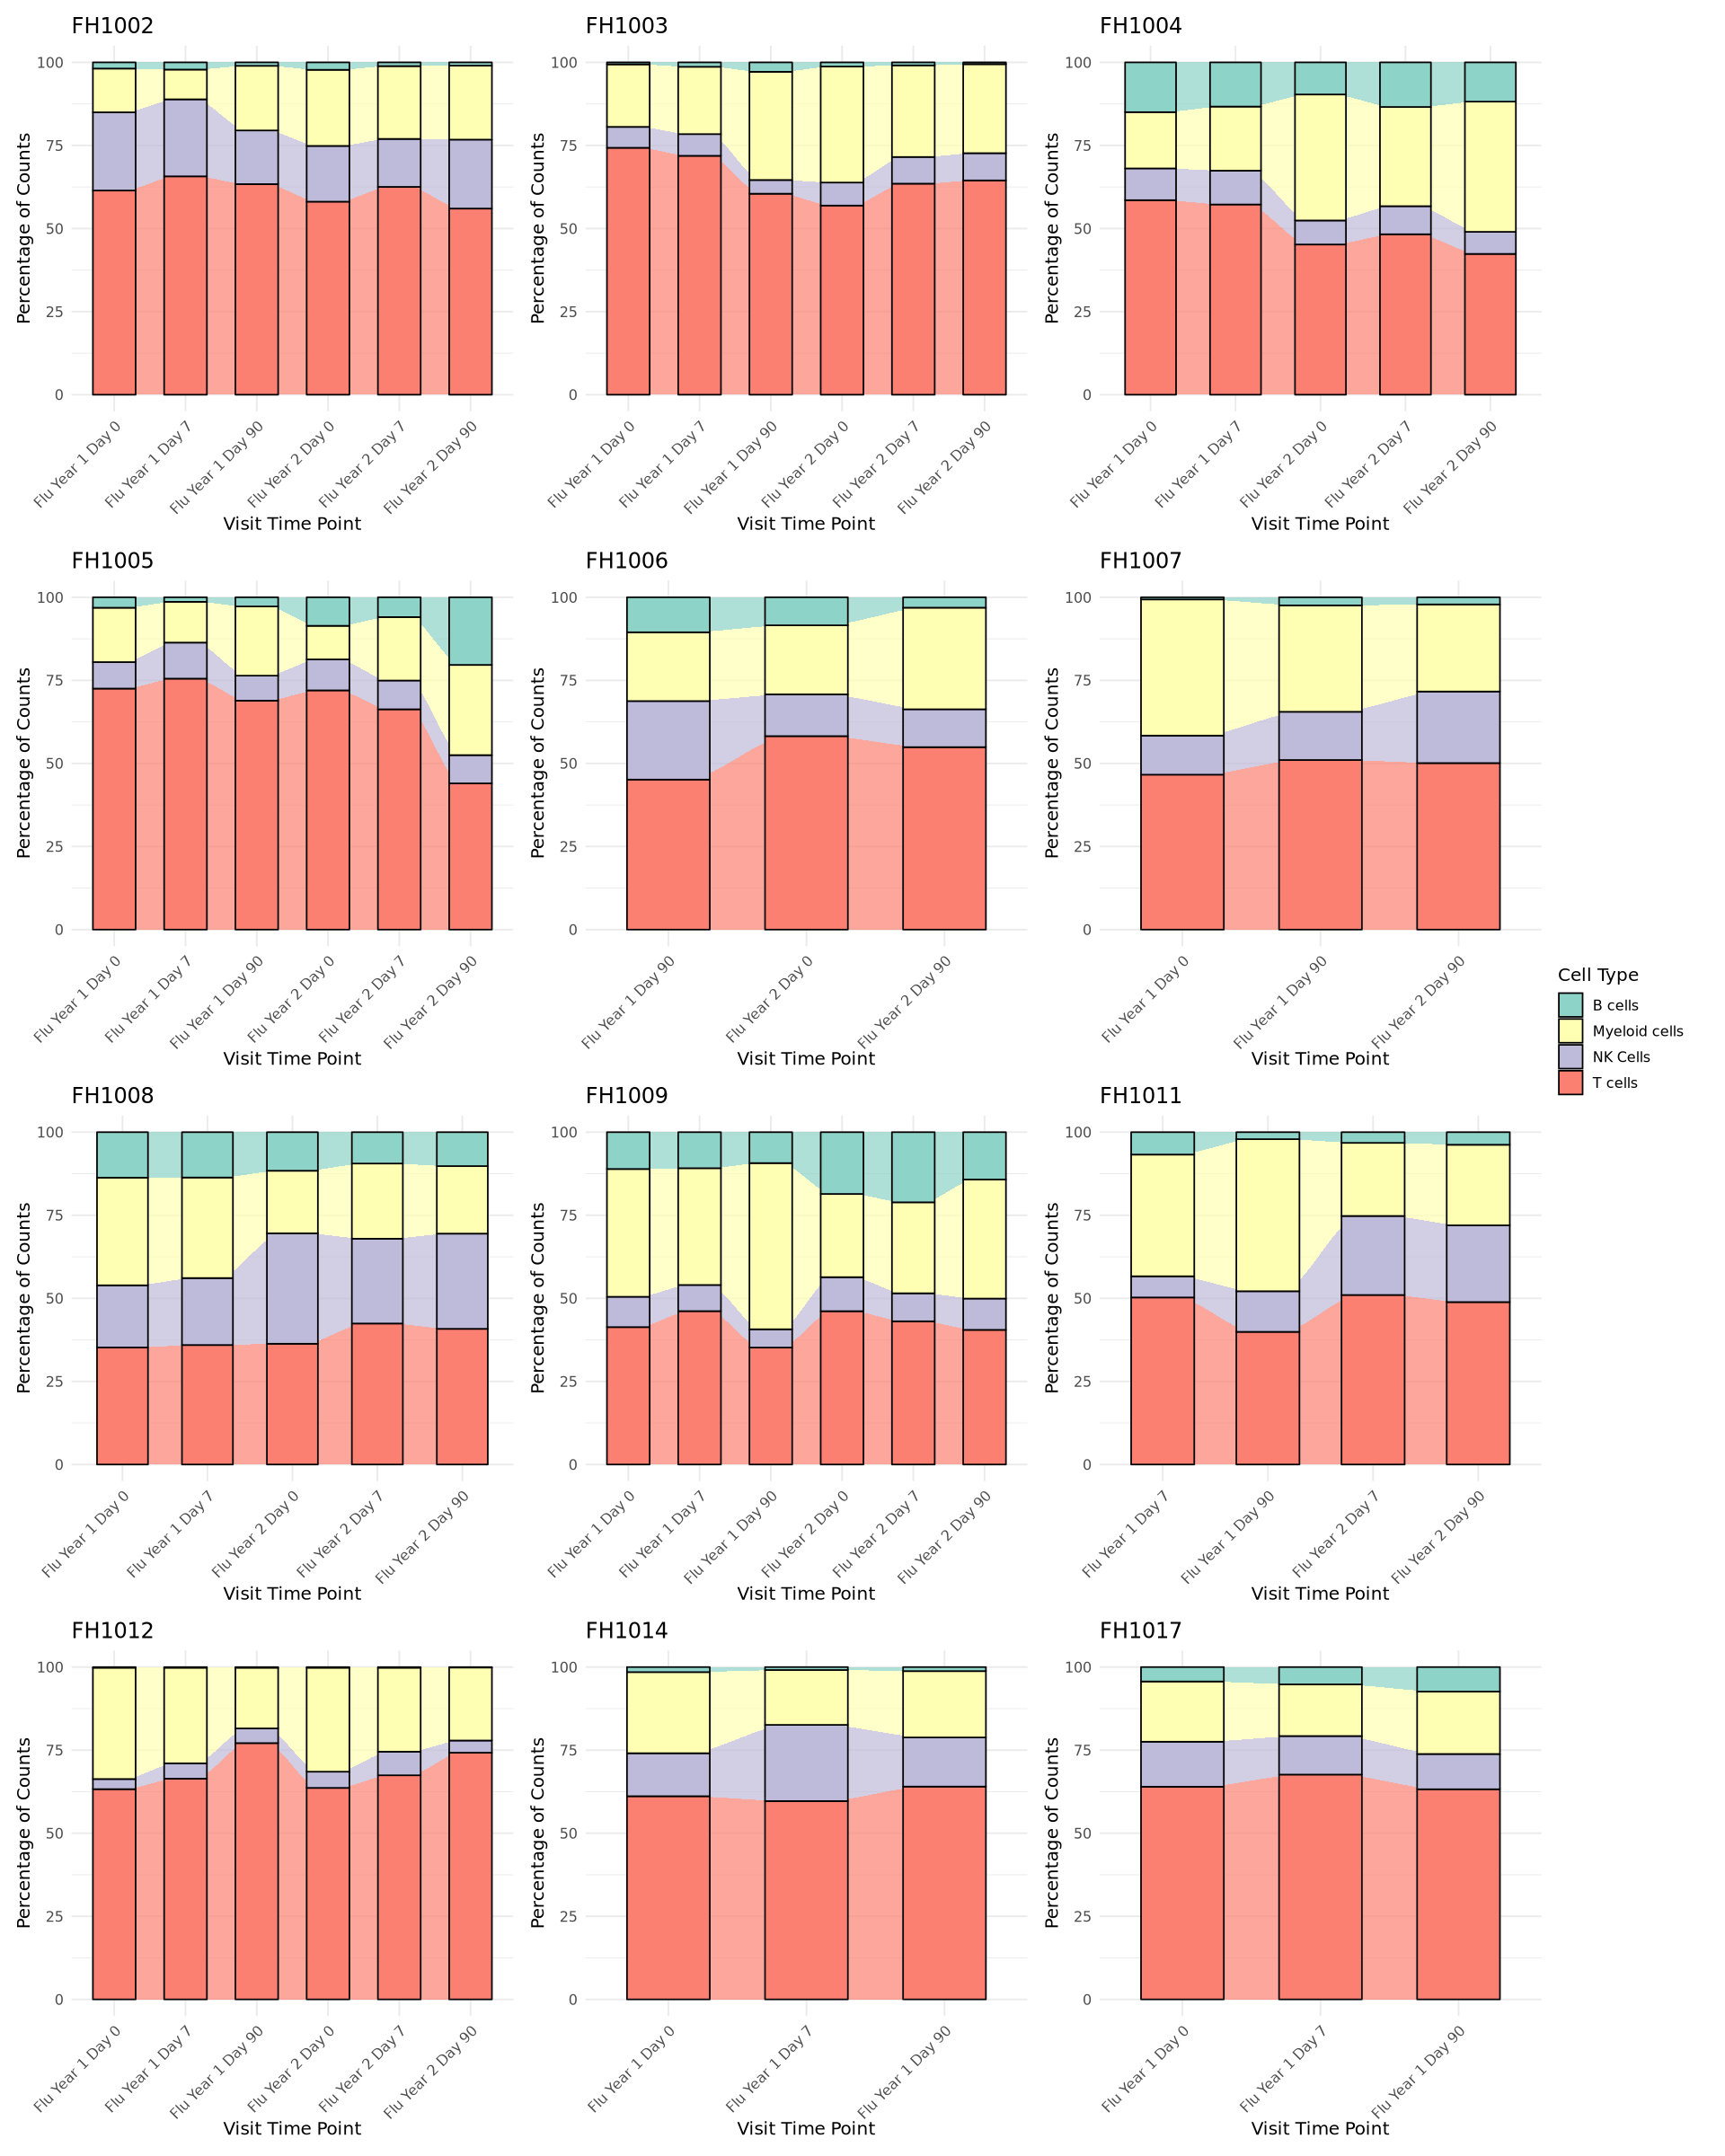

In [2]:
# ============================================================================
# Set plot display options and load required libraries
# ============================================================================
options(repr.plot.width = 16, repr.plot.height = 20)  # Set large plot dimensions for multi-panel display

library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)
library(patchwork)    # Combining multiple plots into panels

# ============================================================================
# Load data and identify all subjects for analysis
# ============================================================================
df <- read.csv('/home/workspace/pbmc_flow/data/FH PBMC T Cell data - Cleaned Counts.csv')  # Load cleaned PBMC data
subjects <- unique(df$Subject)  # Get list of all unique subjects in dataset

# ============================================================================
# Create individual alluvial plots for each subject
# ============================================================================
plots <- lapply(seq_along(subjects), function(x) {  # Loop through each subject to create individual plots

    # Defining metadata columns
    metadata <- c(
        "AIFI.Barcode",
        "Sample.Kit.Barcode",
        "Subject",
        "Visit",
        "Visit.Type"
    )

    # Define celltype columns to plot
    cell_cols <- c(
        "B.cells.count",
        "T.cells.count",
        "Myeloid.cells.count",
        "NK.Cells.count"
    )
    
    # Define flu vaccine study timepoints to analyze
    timepoints <- c(                       
        "Flu Year 1 Day 0",
        "Flu Year 1 Day 7",
        "Flu Year 1 Day 90",
        "Flu Year 2 Day 0",
        "Flu Year 2 Day 7",
        "Flu Year 2 Day 90"
    )
    
    # Filter data for current subject and timepoints
    subject_df <- df[df$Subject == subjects[x], ]          # Extract data for current subject
    subject_df <- subject_df[subject_df$Visit.Type %in% timepoints, ]      # Keep only specified timepoints
    subject_df <- subject_df[, c(metadata, cell_cols)]              # Keep only metadata and cell count columns
    
    # Clean column names and identify count columns
    names(subject_df) <- gsub("\\.", " ", names(subject_df))      # Replace periods with spaces in column names
    count_cols <- gsub("\\.", " ", cell_cols)                     # Replace periods with spaces in column names
    
    # Convert absolute counts to percentages
    row_totals <- rowSums(subject_df[, count_cols])       # Calculate total cells per timepoint
    percentages <- subject_df[,]                          # Create copy of dataframe
    percentages[, count_cols] <- (subject_df[, count_cols] / row_totals) * 100  # Convert to percentages
    
    # Reshape data from wide to long format for ggplot
    selected_data <- select(percentages, c("Visit Type", count_cols))  # Select columns needed for plot
    
    long_data <- pivot_longer(selected_data,      # Convert to long format
                             cols = all_of(count_cols), 
                             names_to = "cell_type", 
                             values_to = "percentage")
    
    # Clean data and set proper factor ordering
    long_data$cell_type <- gsub(" count", "", long_data$cell_type)                      # Remove " count" from cell type names
    long_data$`Visit Type` <- factor(long_data$`Visit Type`, levels = timepoints)       # Order timepoints chronologically
    
    # Create color palette based on number of cell types
    n_cell_types <- length(unique(long_data$cell_type))  # Count unique cell types
    if (n_cell_types <= 12) {
        colors <- brewer.pal(max(3, n_cell_types), "Set3")  # Use Set3 palette for ≤12 types
    } else {
        colors <- c(brewer.pal(12, "Paired"), brewer.pal(8, "Set1"))[1:n_cell_types]  # Combine palettes for >12 types
    }
    
    # Create and customize alluvial plot for current subject
    p <- ggplot(long_data, aes(x = `Visit Type`,   # Initialize plot with alluvial aesthetics
                            stratum = cell_type, 
                            alluvium = cell_type, 
                            y = percentage, 
                            fill = cell_type)) +
        geom_alluvium(width = 0.1, alpha = 0.7) +  # Add flowing bands between timepoints
        geom_stratum(width = 0.6) +                # Add stacked segments at each timepoint
        scale_fill_manual(values = colors) +       # Apply custom color palette
        theme_minimal(base_size = 12) +            # Use clean minimal theme
        theme(                                     # Customize plot appearance
            legend.position = "right", 
            legend.margin = margin(0, 20, 0, 0),
            axis.text.x = element_text(angle = 45, hjust = 1)
        ) +
        labs(x = "Visit Time Point",                      # Add axis labels
            y = "Percentage of Counts",
            title = subjects[x]) +  # Add current subject ID as plot title
        guides(fill = guide_legend(title = "Cell Type"))  # Set legend title
    
    return(p)  # Return completed plot for this subject
})

# ============================================================================
# Remove problematic subject and prepare plots for combination
# ============================================================================
plots <- plots[-12]  # Remove plot for FH1016 (missing required timepoints)

# Remove legends from all plots except first one for cleaner multi-panel display
patchwork_plots <- lapply(seq_along(plots), function(i) {
  if (i == 1) {
    plots[[i]]  # Keep legend on first plot
  } else {
    plots[[i]] + theme(legend.position = "none")  # Remove legend from other plots
  }
})

# ============================================================================
# Combine all individual plots into multi-panel figure
# ============================================================================
final_plot <- wrap_plots(patchwork_plots, ncol = 3) +  # Arrange plots in 3-column grid
  plot_layout(guides = "collect")  # Collect legends into single shared legend

print(final_plot)  # Display the final combined multi-panel plot

### Box Plot

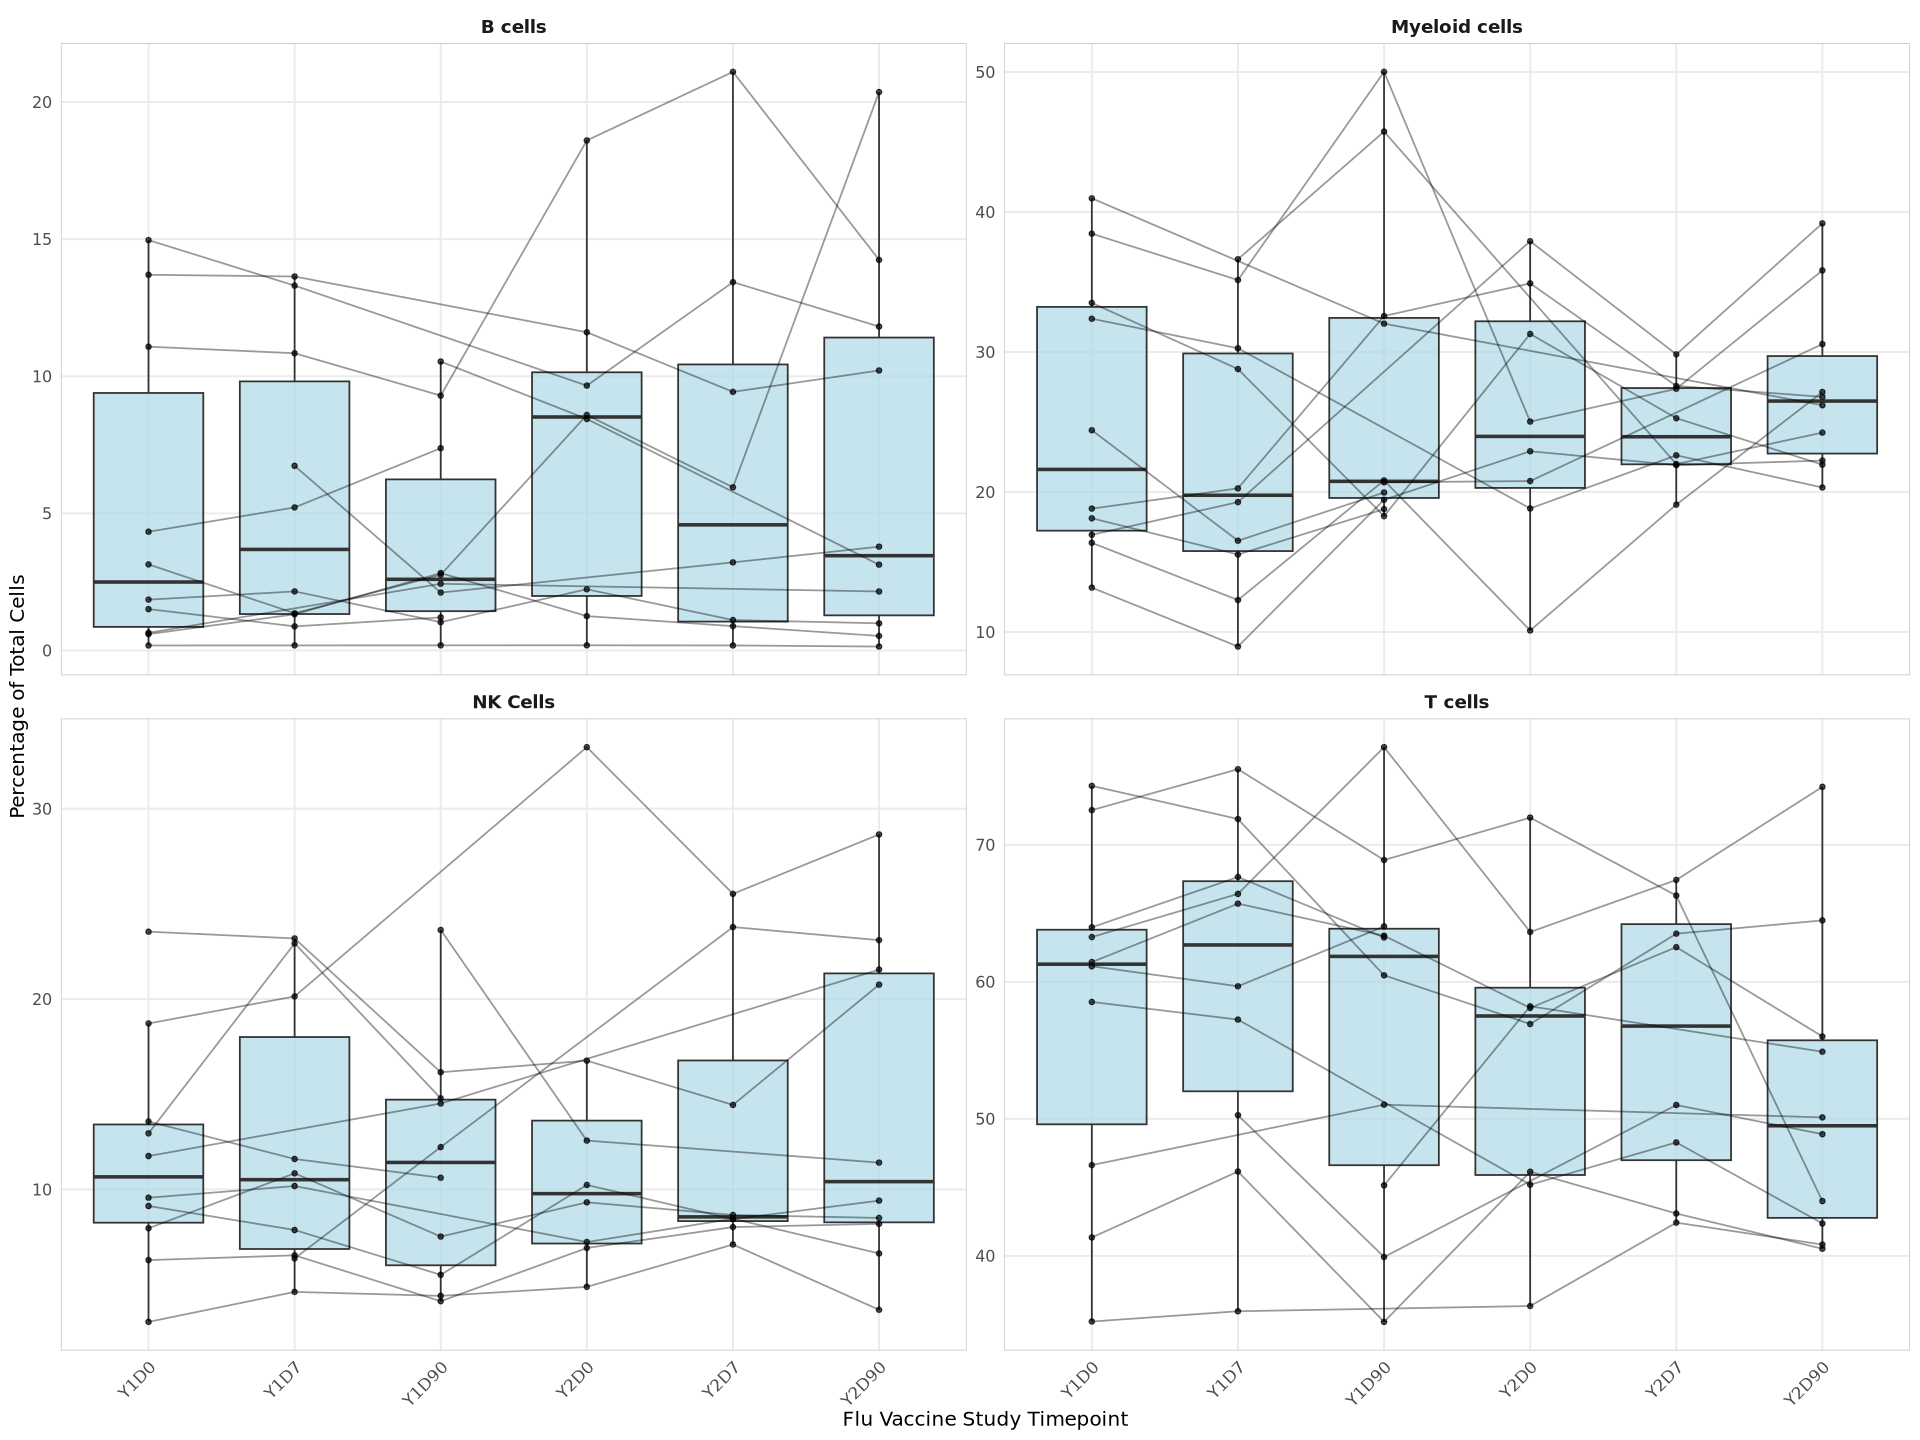

In [5]:
# ============================================================================
# Set plot display options and load required libraries
# ============================================================================
options(repr.plot.width = 16, repr.plot.height = 12)  # Set plot dimensions for faceted display

library(ggplot2)      # Core plotting functionality
library(dplyr)        # Data manipulation
library(tidyr)        # Data reshaping (pivot functions)
library(RColorBrewer) # Color palette generation

# ============================================================================
# Load data and prepare for analysis
# ============================================================================
df <- read.csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - Cleaned Counts.csv')  # Load cleaned PBMC data

# Define column groups for data processing
metadata <- colnames(df)[1:5]          # First 5 columns contain subject info, visit types, etc.
l1_cells <- colnames(df)[c(7:8, 27:28)] # Level 1 cell type count columns

# Define flu vaccine study timepoints to analyze
timepoints <- c(                       
    "Flu Year 1 Day 0",
    "Flu Year 1 Day 7", 
    "Flu Year 1 Day 90",
    "Flu Year 2 Day 0",
    "Flu Year 2 Day 7",
    "Flu Year 2 Day 90"
)

# ============================================================================
# Process data for all subjects combined
# ============================================================================
# Filter data for all subjects and specified timepoints
filtered_df <- df[df$Visit.Type %in% timepoints, ]      # Keep only specified timepoints
filtered_df <- filtered_df[, c(metadata, l1_cells)]     # Keep only metadata and cell count columns

# Clean column names
names(filtered_df) <- gsub("\\.", " ", names(filtered_df))      # Replace periods with spaces
count_cols <- colnames(filtered_df)[6:9]               # Identify columns containing cell counts

# Convert absolute counts to percentages for each row
row_totals <- rowSums(filtered_df[, count_cols])       # Calculate total cells per timepoint
percentages <- filtered_df                             # Create copy of dataframe
percentages[, count_cols] <- (filtered_df[, count_cols] / row_totals) * 100  # Convert to percentages

# ============================================================================
# Reshape data for faceted box plot
# ============================================================================
# Select only the columns needed for plotting
plot_data <- select(percentages, c("Subject", "Visit Type", count_cols))

# Convert to long format
long_data <- pivot_longer(plot_data,
                         cols = all_of(count_cols), 
                         names_to = "cell_type", 
                         values_to = "percentage")

# Clean data and set proper factor ordering
long_data$cell_type <- gsub(" count", "", long_data$cell_type)                      # Remove " count" from cell type names
long_data$`Visit Type` <- factor(long_data$`Visit Type`, levels = timepoints)       # Order timepoints chronologically

# Create simplified timepoint labels for x-axis
long_data$timepoint_short <- case_when(
    long_data$`Visit Type` == "Flu Year 1 Day 0" ~ "Y1D0",
    long_data$`Visit Type` == "Flu Year 1 Day 7" ~ "Y1D7", 
    long_data$`Visit Type` == "Flu Year 1 Day 90" ~ "Y1D90",
    long_data$`Visit Type` == "Flu Year 2 Day 0" ~ "Y2D0",
    long_data$`Visit Type` == "Flu Year 2 Day 7" ~ "Y2D7",
    long_data$`Visit Type` == "Flu Year 2 Day 90" ~ "Y2D90"
)
long_data$timepoint_short <- factor(long_data$timepoint_short, 
                                   levels = c("Y1D0", "Y1D7", "Y1D90", "Y2D0", "Y2D7", "Y2D90"))

# ============================================================================
# Create faceted box plot
# ============================================================================
# Create the faceted box plot with subject trajectories
faceted_plot <- ggplot(long_data, aes(x = timepoint_short, y = percentage)) +
    geom_boxplot(fill = "lightblue", alpha = 0.7, outlier.shape = NA) +  # Create box plots, hide default outliers
    geom_line(aes(group = Subject), alpha = 0.4, size = 0.5) +           # Connect points for each subject
    geom_point(alpha = 0.7, size = 1.2) +                               # Add individual data points
    facet_wrap(~ cell_type, scales = "free_y", ncol = 2) +              # Create separate panel for each cell type
    theme_minimal(base_size = 12) +                                    # Use clean minimal theme
    theme(
        strip.text = element_text(size = 11, face = "bold"),           # Style facet labels
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10),  # Rotate x-axis labels
        panel.grid.minor = element_blank(),                            # Remove minor grid lines
        panel.border = element_rect(color = "gray80", fill = NA, size = 0.5)  # Add panel borders
    ) +
    labs(
        x = "Flu Vaccine Study Timepoint",
        y = "Percentage of Total Cells"
    )

print(faceted_plot)

## Level 2 Celltypes

### Alluvial Plot

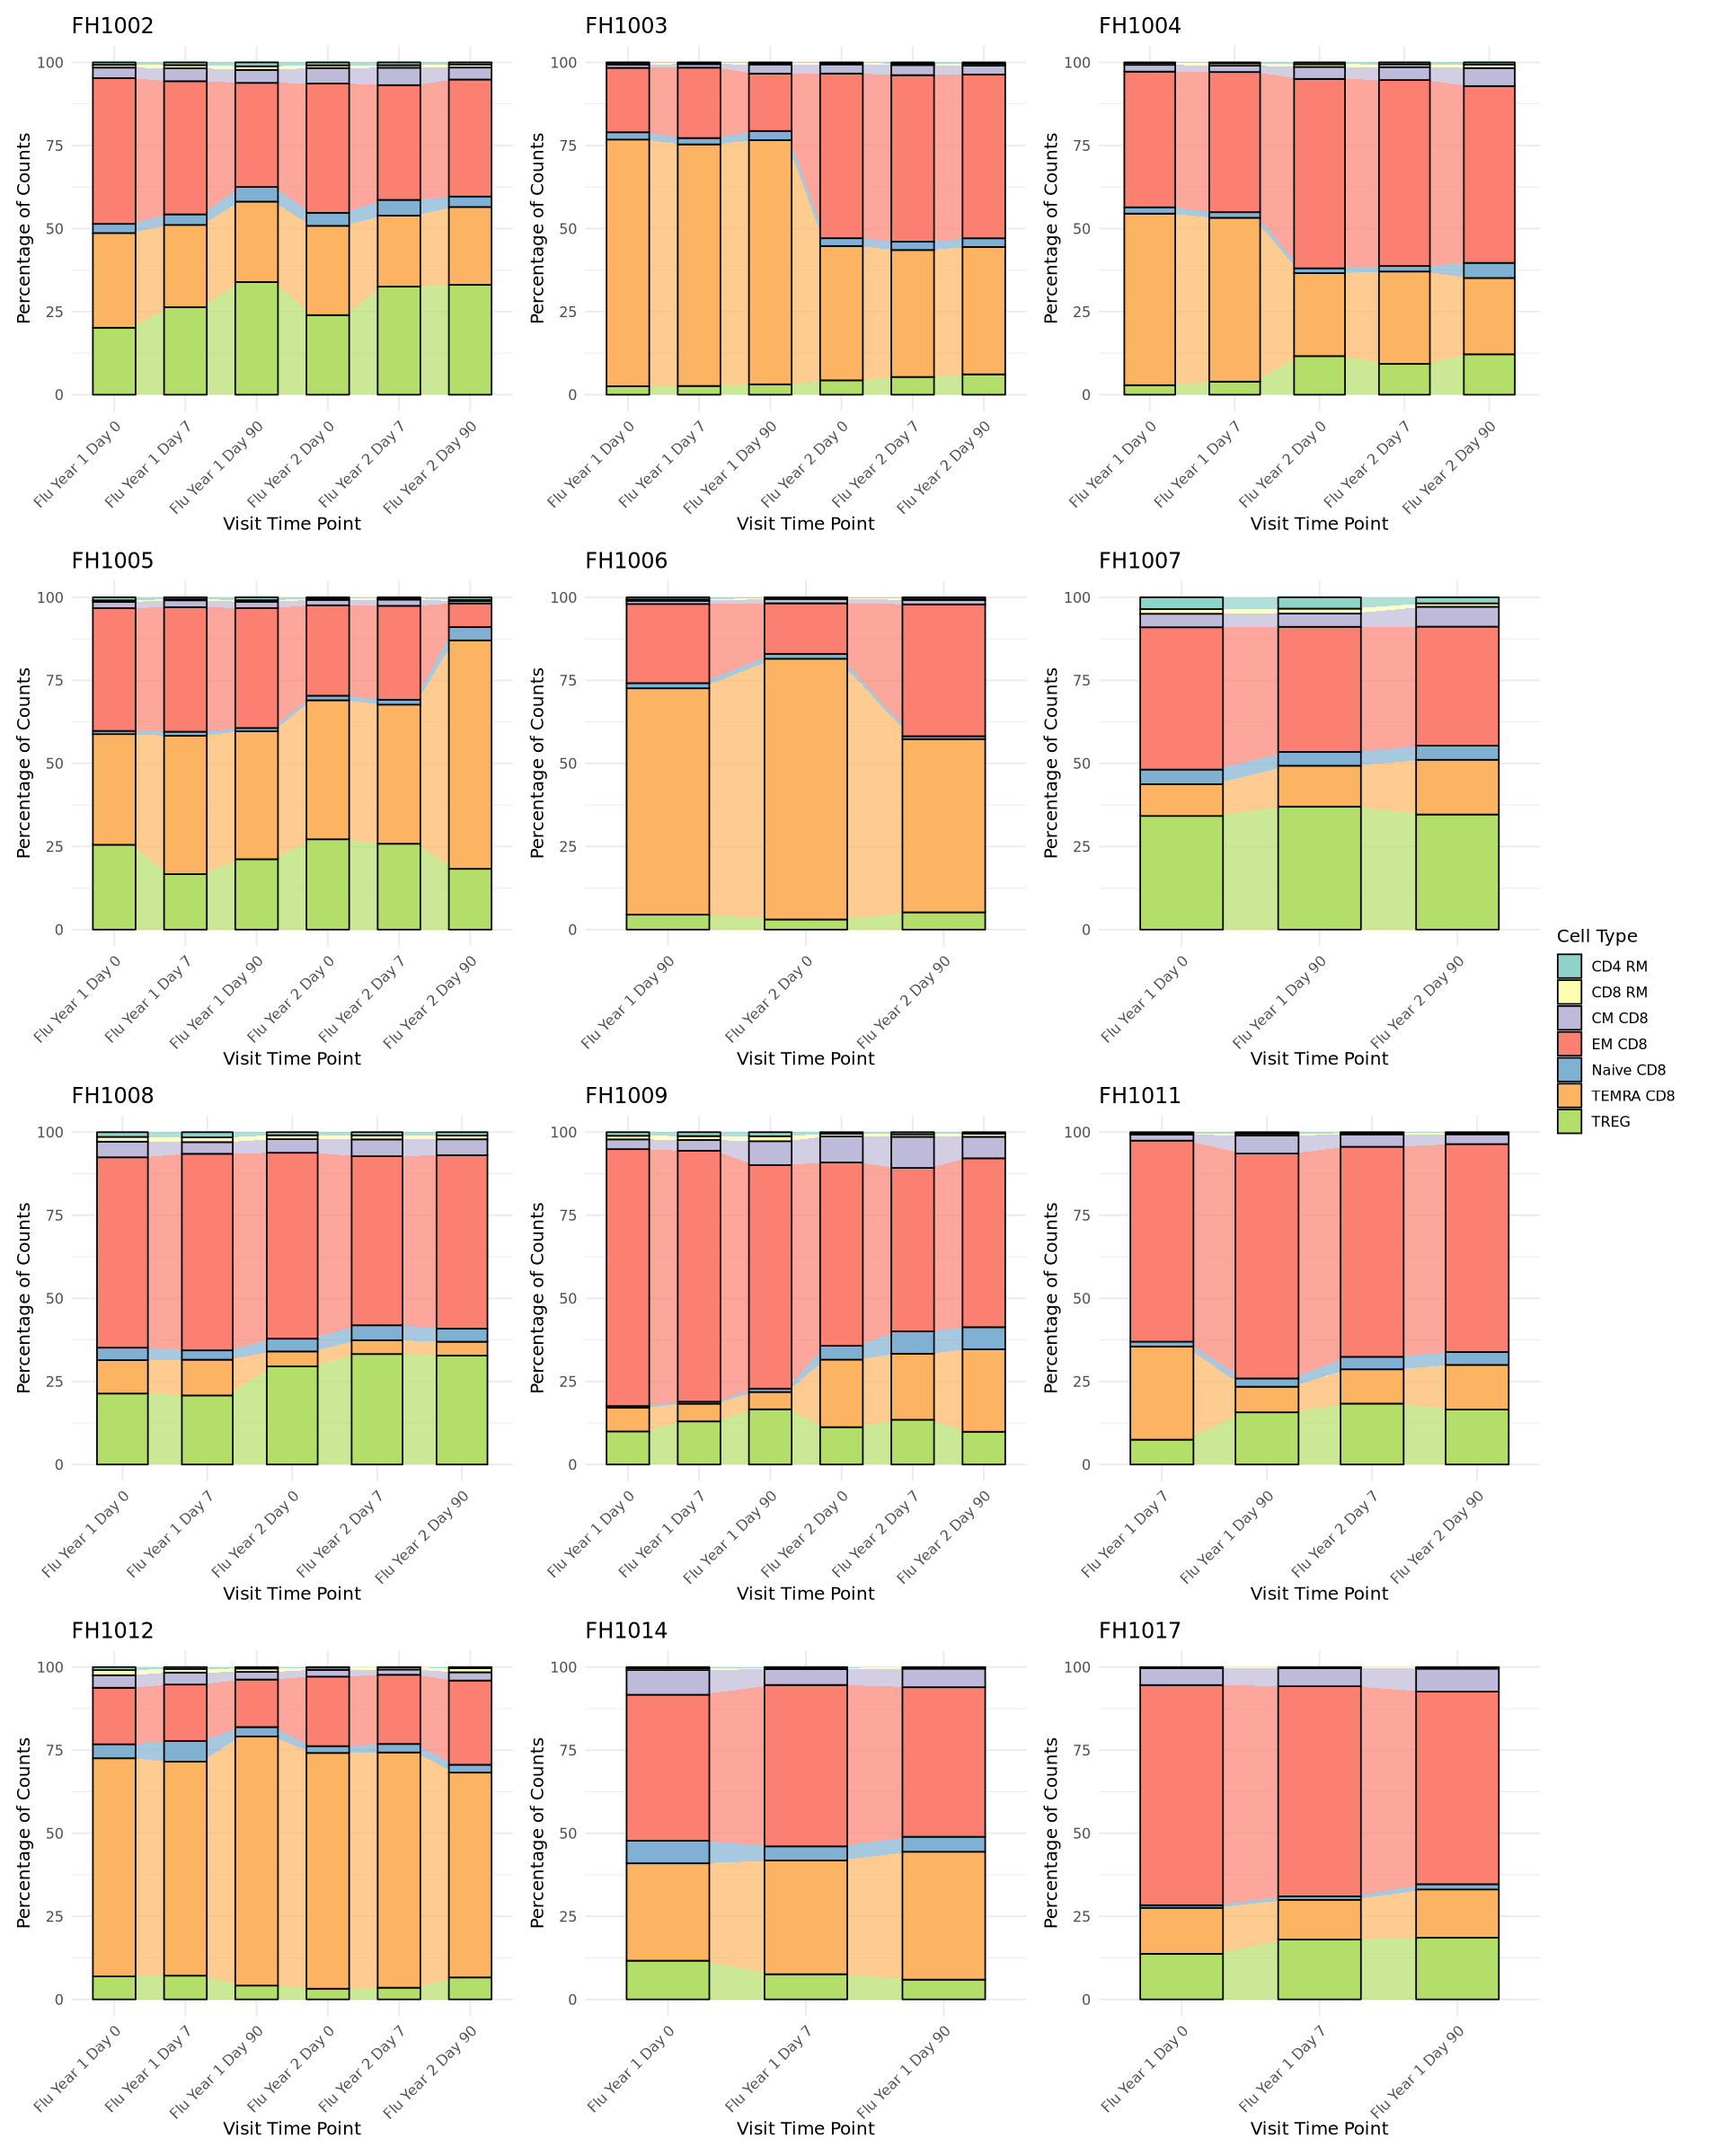

In [5]:
# ============================================================================
# Set plot display options and load required libraries
# ============================================================================
options(repr.plot.width = 16, repr.plot.height = 20)  # Set large plot dimensions for multi-panel display

library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)
library(patchwork)    # Combining multiple plots into panels

# ============================================================================
# Load data and identify all subjects for analysis
# ============================================================================
df <- read.csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - Cleaned Counts.csv')  # Load cleaned PBMC data
subjects <- unique(df$Subject)  # Get list of all unique subjects in dataset

# ============================================================================
# Create individual alluvial plots for each subject
# ============================================================================
plots <- lapply(seq_along(subjects), function(x) {  # Loop through each subject to create individual plots

    # Defining metadata columns
    metadata <- c(
        "AIFI.Barcode",
        "Sample.Kit.Barcode",
        "Subject",
        "Visit",
        "Visit.Type"
    )

    # Define celltype columns to plot
    cell_cols <- c('Naive.CD8..count', 'TEMRA.CD8.count', 'EM.CD8.count', 'CM.CD8.count', 'CD8.RM.count', 'CD4.RM.count', 'TREG.count')

    # Define flu vaccine study timepoints to analyze
    timepoints <- c(                       
        "Flu Year 1 Day 0",
        "Flu Year 1 Day 7",
        "Flu Year 1 Day 90",
        "Flu Year 2 Day 0",
        "Flu Year 2 Day 7",
        "Flu Year 2 Day 90"
    )
    
    # Filter data for current subject and timepoints
    subject_df <- df[df$Subject == subjects[x], ]          # Extract data for current subject
    subject_df <- subject_df[subject_df$Visit.Type %in% timepoints, ]      # Keep only specified timepoints
    subject_df <- subject_df[, c(metadata, cell_cols)]              # Keep only metadata and cell count columns
    
    # Clean column names and identify count columns
    names(subject_df) <- gsub("\\.", " ", names(subject_df))      # Replace periods with spaces in column names
    count_cols <- gsub("\\.", " ", cell_cols)                     # Replace periods with spaces in column names
    
    # Convert absolute counts to percentages
    row_totals <- rowSums(subject_df[, count_cols])       # Calculate total cells per timepoint
    percentages <- subject_df[,]                          # Create copy of dataframe
    percentages[, count_cols] <- (subject_df[, count_cols] / row_totals) * 100  # Convert to percentages
    
    # Reshape data from wide to long format for ggplot
    selected_data <- select(percentages, c("Visit Type", all_of(count_cols)))  # Select columns needed for plot
    
    long_data <- pivot_longer(selected_data,      # Convert to long format
                             cols = all_of(count_cols), 
                             names_to = "cell_type", 
                             values_to = "percentage")
    
    # Clean data and set proper factor ordering
    long_data$cell_type <- gsub(" count", "", long_data$cell_type)                      # Remove " count" from cell type names
    long_data$`Visit Type` <- factor(long_data$`Visit Type`, levels = timepoints)       # Order timepoints chronologically
    
    # Create color palette based on number of cell types
    n_cell_types <- length(unique(long_data$cell_type))  # Count unique cell types
    if (n_cell_types <= 12) {
        colors <- brewer.pal(max(3, n_cell_types), "Set3")  # Use Set3 palette for ≤12 types
    } else {
        colors <- c(brewer.pal(12, "Paired"), brewer.pal(8, "Set1"))[1:n_cell_types]  # Combine palettes for >12 types
    }
    
    # Create and customize alluvial plot for current subject
    p <- ggplot(long_data, aes(x = `Visit Type`,   # Initialize plot with alluvial aesthetics
                            stratum = cell_type, 
                            alluvium = cell_type, 
                            y = percentage, 
                            fill = cell_type)) +
        geom_alluvium(width = 0.1, alpha = 0.7) +  # Add flowing bands between timepoints
        geom_stratum(width = 0.6) +                # Add stacked segments at each timepoint
        scale_fill_manual(values = colors) +       # Apply custom color palette
        theme_minimal(base_size = 12) +            # Use clean minimal theme
        theme(                                     # Customize plot appearance
            legend.position = "right", 
            legend.margin = margin(0, 20, 0, 0),
            axis.text.x = element_text(angle = 45, hjust = 1)
        ) +
        labs(x = "Visit Time Point",                      # Add axis labels
            y = "Percentage of Counts",
            title = subjects[x]) +  # Add current subject ID as plot title
        guides(fill = guide_legend(title = "Cell Type"))  # Set legend title
    
    return(p)  # Return completed plot for this subject
})

# ============================================================================
# Remove problematic subject and prepare plots for combination
# ============================================================================
plots <- plots[-12]  # Remove plot for FH1016 (missing required timepoints)

# Remove legends from all plots except first one for cleaner multi-panel display
patchwork_plots <- lapply(seq_along(plots), function(i) {
  if (i == 1) {
    plots[[i]]  # Keep legend on first plot
  } else {
    plots[[i]] + theme(legend.position = "none")  # Remove legend from other plots
  }
})

# ============================================================================
# Combine all individual plots into multi-panel figure
# ============================================================================
final_plot <- wrap_plots(patchwork_plots, ncol = 3) +  # Arrange plots in 3-column grid
  plot_layout(guides = "collect")  # Collect legends into single shared legend

print(final_plot)  # Display the final combined multi-panel plot

### Box Plot

## Level 3 Celltypes

### Alluvial Plot

In [ ]:
# ============================================================================
# Set plot display options and load required libraries
# ============================================================================
options(repr.plot.width = 16, repr.plot.height = 20)  # Set large plot dimensions for multi-panel display

library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)
library(patchwork)    # Combining multiple plots into panels

# ============================================================================
# Load data and identify all subjects for analysis
# ============================================================================
df <- read.csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - Cleaned Counts.csv')  # Load cleaned PBMC data
subjects <- unique(df$Subject)  # Get list of all unique subjects in dataset

# ============================================================================
# Create individual alluvial plots for each subject
# ============================================================================
plots <- lapply(seq_along(subjects), function(x) {  # Loop through each subject to create individual plots

    # Defining metadata columns
    metadata <- c(
        "AIFI.Barcode",
        "Sample.Kit.Barcode",
        "Subject",
        "Visit",
        "Visit.Type"
    )

    # Define celltype columns to plot
    cell_cols <- c('Naive.CD8..count', 'TEMRA.CD8.count', 'EM.CD8.count', 'CM.CD8.count', 'CD8.RM.count', 'CD4.RM.count', 'TREG.count')

    # Define flu vaccine study timepoints to analyze
    timepoints <- c(                       
        "Flu Year 1 Day 0",
        "Flu Year 1 Day 7",
        "Flu Year 1 Day 90",
        "Flu Year 2 Day 0",
        "Flu Year 2 Day 7",
        "Flu Year 2 Day 90"
    )
    
    # Filter data for current subject and timepoints
    subject_df <- df[df$Subject == subjects[x], ]          # Extract data for current subject
    subject_df <- subject_df[subject_df$Visit.Type %in% timepoints, ]      # Keep only specified timepoints
    subject_df <- subject_df[, c(metadata, cell_cols)]              # Keep only metadata and cell count columns
    
    # Clean column names and identify count columns
    names(subject_df) <- gsub("\\.", " ", names(subject_df))      # Replace periods with spaces in column names
    count_cols <- gsub("\\.", " ", cell_cols)                     # Replace periods with spaces in column names
    
    # Convert absolute counts to percentages
    row_totals <- rowSums(subject_df[, count_cols])       # Calculate total cells per timepoint
    percentages <- subject_df[,]                          # Create copy of dataframe
    percentages[, count_cols] <- (subject_df[, count_cols] / row_totals) * 100  # Convert to percentages
    
    # Reshape data from wide to long format for ggplot
    selected_data <- select(percentages, c("Visit Type", all_of(count_cols)))  # Select columns needed for plot
    
    long_data <- pivot_longer(selected_data,      # Convert to long format
                             cols = all_of(count_cols), 
                             names_to = "cell_type", 
                             values_to = "percentage")
    
    # Clean data and set proper factor ordering
    long_data$cell_type <- gsub(" count", "", long_data$cell_type)                      # Remove " count" from cell type names
    long_data$`Visit Type` <- factor(long_data$`Visit Type`, levels = timepoints)       # Order timepoints chronologically
    
    # Create color palette based on number of cell types
    n_cell_types <- length(unique(long_data$cell_type))  # Count unique cell types
    if (n_cell_types <= 12) {
        colors <- brewer.pal(max(3, n_cell_types), "Set3")  # Use Set3 palette for ≤12 types
    } else {
        colors <- c(brewer.pal(12, "Paired"), brewer.pal(8, "Set1"))[1:n_cell_types]  # Combine palettes for >12 types
    }
    
    # Create and customize alluvial plot for current subject
    p <- ggplot(long_data, aes(x = `Visit Type`,   # Initialize plot with alluvial aesthetics
                            stratum = cell_type, 
                            alluvium = cell_type, 
                            y = percentage, 
                            fill = cell_type)) +
        geom_alluvium(width = 0.1, alpha = 0.7) +  # Add flowing bands between timepoints
        geom_stratum(width = 0.6) +                # Add stacked segments at each timepoint
        scale_fill_manual(values = colors) +       # Apply custom color palette
        theme_minimal(base_size = 12) +            # Use clean minimal theme
        theme(                                     # Customize plot appearance
            legend.position = "right", 
            legend.margin = margin(0, 20, 0, 0),
            axis.text.x = element_text(angle = 45, hjust = 1)
        ) +
        labs(x = "Visit Time Point",                      # Add axis labels
            y = "Percentage of Counts",
            title = subjects[x]) +  # Add current subject ID as plot title
        guides(fill = guide_legend(title = "Cell Type"))  # Set legend title
    
    return(p)  # Return completed plot for this subject
})

# ============================================================================
# Remove problematic subject and prepare plots for combination
# ============================================================================
plots <- plots[-12]  # Remove plot for FH1016 (missing required timepoints)

# Remove legends from all plots except first one for cleaner multi-panel display
patchwork_plots <- lapply(seq_along(plots), function(i) {
  if (i == 1) {
    plots[[i]]  # Keep legend on first plot
  } else {
    plots[[i]] + theme(legend.position = "none")  # Remove legend from other plots
  }
})

# ============================================================================
# Combine all individual plots into multi-panel figure
# ============================================================================
final_plot <- wrap_plots(patchwork_plots, ncol = 3) +  # Arrange plots in 3-column grid
  plot_layout(guides = "collect")  # Collect legends into single shared legend

print(final_plot)  # Display the final combined multi-panel plot

### Box Plot